# Метрика точности кластеризации

In [35]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.utils.linear_assignment_ import linear_assignment


nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Вычисляет точность кластеризации.
    # Arguments
        y_true: истинные метки, np.array с shape = (n_samples,)
        y_pred: предсказанные метки, np.array с shape = (n_samples,)
    # Return
        accuracy в отрезке [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

# Базовый алгоритм кластеризации K-Means (unsupervised)
Традиционный алгоритм K-средних быстр и применим к широкому кругу задач. Однако их метрики расстояния ограничены исходным пространством данных, и они, как правило, неэффективны, когда входная размерность высока, например, как у изображений.

Давайте обучим модель K-средних для кластеризации рукописных цифр MNIST в 10 кластеров.

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.) # нормализуем в [0, 1]
n_clusters = len(np.unique(y)) # 10 кластеров
# Запускаем параллельно 2 CPUs
# n_init - число выборов различных центроиды, в итоге - лучший выбор
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=2) 
# Тренировка K-Means.
y_pred_kmeans = kmeans.fit_predict(x)
# Вычисляем K-Means accuracy кластеризации.
print(acc(y, y_pred_kmeans))

11493376/11490434 [==============================] - 0s 0us/step
0.5332428571428571


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Оценка точности кластеризации K-средних составляет  **53,2%**.

# Unsupervised Clustering with Autoncoder on Keras
[Статья первоисточник](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/)

## Импорт необходимых библиотек

In [36]:
from keras.datasets import mnist
import numpy as np
from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

## Модель Автоэкодера

In [37]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Полносвязная симметричная модель autoencoder.
    Arguments:
        dims: список количеств нейроннов на каждом слое энкодера. dims[0] = это
              разменрность input, dims[-1] размерность скрытого слоя.
              Декодер симметричен энкодеру. Поэтому число слоев autoencoder
              равно 2*len(dims)-1 (-1 так как один скрытый слой). 
        act: activation, не применяется к Input, Hidden и Output layers.
        init: начальная инициализация весов
    return:
        (ae_model, encoder_model), Модель autoencoder и модель encoder.
    """
    n_stacks = len(dims) - 1
    # Input слой
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # внутренние слои encoder
    for i in range(n_stacks - 1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, 
                  name='encoder_{}'.format(i))(x)

    # скрытый слой - признаки извлекаются из него
    encoded = Dense(dims[-1], kernel_initializer=init,
                    name='encoder_{}'.format((n_stacks - 1)))(x)

    x = encoded
    # внутренние слои decoder
    for i in range(n_stacks - 1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init,
                  name='decoder_{}'.format(i))(x)

    # Output слой
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), \
           Model(inputs=input_img, outputs=encoded, name='encoder')

### Задание гиперпараметров

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = len(np.unique(y))
x.shape

dims = [x.shape[-1], 500, 500, 2000, 10]
# VarianceScaling - инициализатор, способный адаптировать свой shape к
#                   весам тензора.
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './'

In [39]:
autoencoder, encoder = autoencoder(dims, init=init)

### Рисуем архитектуру Автоэнкодера

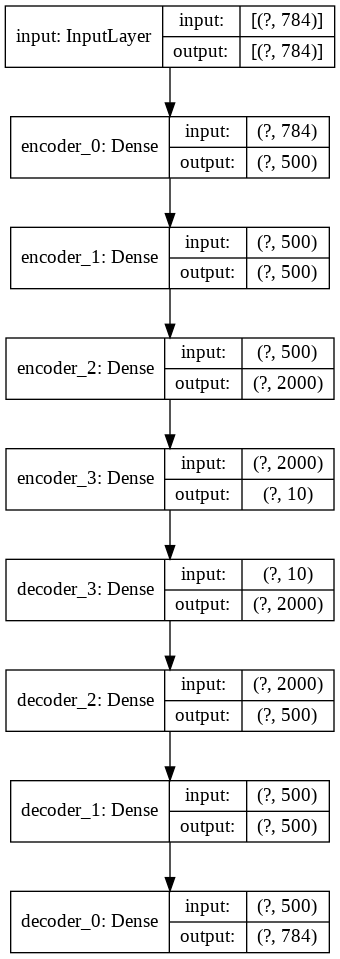

In [9]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

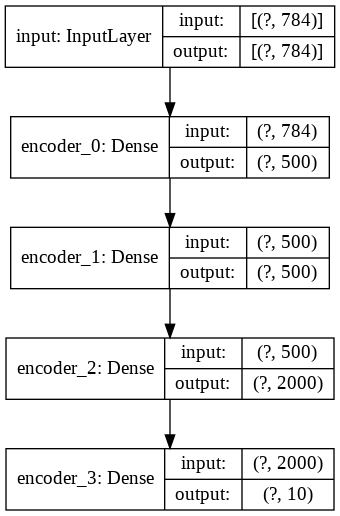

In [10]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 

### Тренируем Автоэнкодер

In [8]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)

Epoch 1/300
274/274 [==============================] - 1s 5ms/step - loss: 0.0645
Epoch 2/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0442
Epoch 3/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0323
Epoch 4/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0268
Epoch 5/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0241
Epoch 6/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0225
Epoch 7/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0213
Epoch 8/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0203
Epoch 9/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0196
Epoch 10/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0189
Epoch 11/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0184
Epoch 12/300
274/274 [==============================] - 1s 4ms/step - loss: 0.0179
Epoch 13/300


OSError: ignored

### Сохранение весов Автоэнкодера

In [10]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

### Загрузка весов автоэкодера

In [40]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Построение модели кластеризации

#### Clustering layer

In [41]:
class ClusteringLayer(Layer):
    """
    Слой кластеризации преобразует входные признаки экземпляра к soft label -
    вектор, который представляет вероятность экземпляра принадлежать к каждому
    из классов. Вероятность вычисляется с помощью распределения Стьюдента.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: число кластеров.
        weights: список Numpy array with shape = (n_clusters, n_features) который
                 представляет начальные центры кластеров.
        alpha: число степень свободы - параметр распределения Стьюдента.
               По умолчанию 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2) # для проверки совместимости

    def build(self, input_shape):
        """
        Определяем веса слоя, в нашем случае 10 кластеров в 10-мерном
        пространстве объектов, это 10x10 весовые переменные.
        """
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim),
                                initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """
        Распределение Стьюдента, то, которое используется в t-SNE алгоритме.
        Измеряет схожесть между встроенной точкой z_i и центроидом µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), нормализует это
                 q_ij может интерпретироваться как вероятность назначения 
                      экземпляру i кластера j. (то есть soft clustering)
        Arguments:
            inputs: переменная, содержащая данные, shape=(n_samples, n_features)
        Return:
            q: Распределение стьюдента, or soft labels для каждого экземпляра.
               shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - \
                                         self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        """Логика преобразования формы от входной формы к выходной."""
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#### Итоговая модель кластеризации

In [42]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

#### Рисуем модель кластеризации

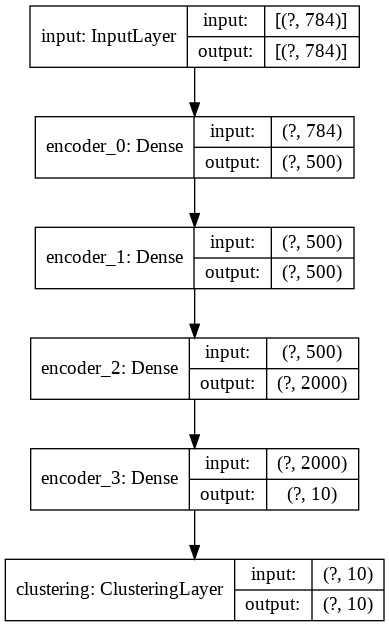

In [13]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

#### Step 1: инициализация центров кластеров, используя K-Means



In [43]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

#### Step 2: глубинная кластеризация
Вычислите p_i, сначала возведя q_i во вторую степень, а затем нормализуя по частоте для каждого кластера:



In [44]:
# Вычисление вспомогательного целевого распределения
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [45]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [46]:
tol = 0.001 # Порог толерантности к прекращению тренировки

### Тренировка модели кластеризации

In [47]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # обновление вспомогательного
                                    # целевого распределения p

        # оценка производительности кластеризации
        y_pred = q.argmax(1)
        if y is not None:
            acc_val = np.round(acc(y, y_pred), 5)
            nmi_val = np.round(nmi(y, y_pred), 5)
            ari_val = np.round(ari(y, y_pred), 5)
            loss_val = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' %\
                  (ite, acc_val, nmi_val, ari_val), ' ; loss=', loss_val)

        # проверка критерия остановки - сходимость модели
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Достигнут порог толерантности. Остановка тренировки.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/model_final.h5')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 0: acc = 0.86137, nmi = 0.79257, ari = 0.75810  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 140: acc = 0.86763, nmi = 0.79790, ari = 0.76900  ; loss= 0.04484


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 280: acc = 0.87390, nmi = 0.80987, ari = 0.78353  ; loss= 0.15314


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 420: acc = 0.87784, nmi = 0.82017, ari = 0.79409  ; loss= 0.20395


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 560: acc = 0.88131, nmi = 0.82760, ari = 0.80210  ; loss= 0.21714


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 700: acc = 0.88304, nmi = 0.83283, ari = 0.80748  ; loss= 0.21388


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 840: acc = 0.88479, nmi = 0.83620, ari = 0.81095  ; loss= 0.208


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 980: acc = 0.88546, nmi = 0.83879, ari = 0.81359  ; loss= 0.2055


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1120: acc = 0.88666, nmi = 0.84146, ari = 0.81648  ; loss= 0.19908


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1260: acc = 0.88676, nmi = 0.84297, ari = 0.81780  ; loss= 0.19863


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1400: acc = 0.88750, nmi = 0.84449, ari = 0.81952  ; loss= 0.19402


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1540: acc = 0.88729, nmi = 0.84480, ari = 0.81939  ; loss= 0.18209


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1680: acc = 0.88761, nmi = 0.84551, ari = 0.82027  ; loss= 0.17434


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1820: acc = 0.88774, nmi = 0.84644, ari = 0.82097  ; loss= 0.18337


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1960: acc = 0.88751, nmi = 0.84687, ari = 0.82127  ; loss= 0.16927


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2100: acc = 0.88754, nmi = 0.84755, ari = 0.82177  ; loss= 0.17068


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2240: acc = 0.88736, nmi = 0.84761, ari = 0.82179  ; loss= 0.16879


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2380: acc = 0.88721, nmi = 0.84774, ari = 0.82170  ; loss= 0.16489


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2520: acc = 0.88707, nmi = 0.84783, ari = 0.82187  ; loss= 0.16158


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2660: acc = 0.88704, nmi = 0.84820, ari = 0.82197  ; loss= 0.16902


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2800: acc = 0.88719, nmi = 0.84878, ari = 0.82247  ; loss= 0.15932


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2940: acc = 0.88690, nmi = 0.84850, ari = 0.82188  ; loss= 0.14844


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3080: acc = 0.88706, nmi = 0.84900, ari = 0.82245  ; loss= 0.15071


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3220: acc = 0.88689, nmi = 0.84891, ari = 0.82214  ; loss= 0.14264


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3360: acc = 0.88699, nmi = 0.84908, ari = 0.82243  ; loss= 0.14161


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3500: acc = 0.88661, nmi = 0.84891, ari = 0.82187  ; loss= 0.14135


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3640: acc = 0.88674, nmi = 0.84904, ari = 0.82208  ; loss= 0.13747


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3780: acc = 0.88696, nmi = 0.84961, ari = 0.82240  ; loss= 0.13114


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3920: acc = 0.88687, nmi = 0.84948, ari = 0.82233  ; loss= 0.13672


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4060: acc = 0.88687, nmi = 0.84976, ari = 0.82239  ; loss= 0.13412


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4200: acc = 0.88690, nmi = 0.84982, ari = 0.82259  ; loss= 0.12441


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4340: acc = 0.88680, nmi = 0.84996, ari = 0.82264  ; loss= 0.12853


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4480: acc = 0.88690, nmi = 0.85003, ari = 0.82274  ; loss= 0.12687


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4620: acc = 0.88697, nmi = 0.85025, ari = 0.82296  ; loss= 0.12371


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4760: acc = 0.88701, nmi = 0.85039, ari = 0.82317  ; loss= 0.12666


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4900: acc = 0.88690, nmi = 0.85016, ari = 0.82288  ; loss= 0.12619


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5040: acc = 0.88699, nmi = 0.85020, ari = 0.82307  ; loss= 0.12215


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5180: acc = 0.88684, nmi = 0.85019, ari = 0.82294  ; loss= 0.11936


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5320: acc = 0.88706, nmi = 0.85054, ari = 0.82336  ; loss= 0.12307


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5460: acc = 0.88706, nmi = 0.85066, ari = 0.82347  ; loss= 0.11996


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5600: acc = 0.88703, nmi = 0.85061, ari = 0.82335  ; loss= 0.12361


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5740: acc = 0.88699, nmi = 0.85059, ari = 0.82333  ; loss= 0.10911
Iter 5880: acc = 0.88700, nmi = 0.85068, ari = 0.82335  ; loss= 0.11851
delta_label  0.0009714285714285714 < tol  0.001
Достигнут порог толерантности. Остановка тренировки.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


### Загрузка весов итоговой модели

In [29]:
model.load_weights(save_dir + '/model_final.h5')

### Оценка итоговой модели

In [48]:
q = model.predict(x, verbose=0)
p = target_distribution(q)   # обновление вспомогательного целевого распределения p

# оценка производительности кластеризации
y_pred = q.argmax(1)
if y is not None:
    acc_val = np.round(acc(y, y_pred), 5)
    nmi_val = np.round(nmi(y, y_pred), 5)
    ari_val = np.round(ari(y, y_pred), 5)
    loss_val = np.round(loss, 5)
    print('acc = %.5f, nmi = %.5f, ari = %.5f' % (acc_val, nmi_val, ari_val),
          ' ; loss=', loss_val)

acc = 0.88700, nmi = 0.85068, ari = 0.82335  ; loss= 0.11851


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


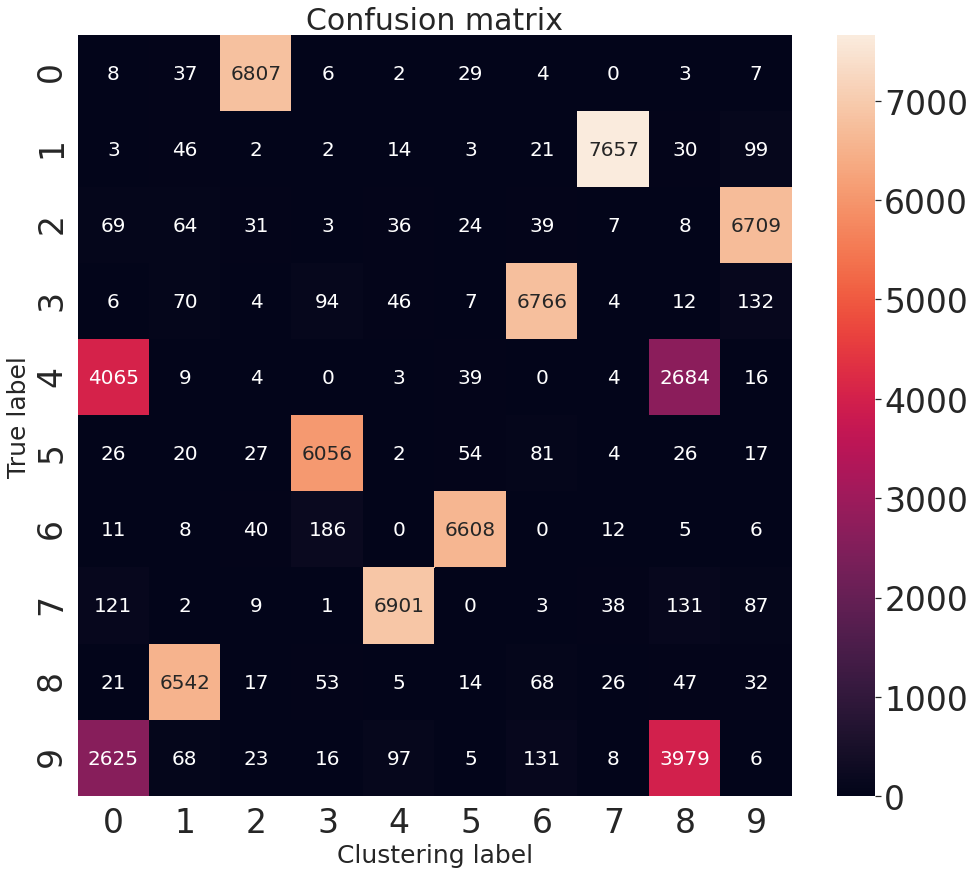

In [49]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()